<a href="https://colab.research.google.com/github/bkleck/WaterAnalytics/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing Datasets and Libraries

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/Surface Water Hydrology

/content/gdrive/MyDrive/Surface Water Hydrology


In [22]:
import pandas as pd
from datetime import datetime, date 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('data/Aquifer_Petrignano_cleaned.csv', index_col=[0])
df.reset_index(drop=True, inplace=True)
df.head()

,date,rainfall,depth_p25,temp_umbra,volume,hydrometry,depth_diff_1,month,day_of_week,week_of_year,season,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,1,3,1,1,0.5,0.866025,0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,1,4,1,1,0.5,0.866025,-0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,1,5,1,1,0.5,0.866025,-0.974928,-0.222521,0.120208,0.992749,1.0,6.123234e-17
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,1,6,1,1,0.5,0.866025,-0.781831,0.623490,0.120208,0.992749,1.0,6.123234e-17
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,1,0,2,1,0.5,0.866025,0.000000,1.000000,0.238673,0.971100,1.0,6.123234e-17


# 2) Univariate Time-Series Forecasting

We will be using 2 metrics to measure our model performance. 

1) **Mean Absolute Error (MAE)**: Measures the average magnitude of errors without considering the directions. It is the average of the absolute difference between predictions and actual observations.

2) **Root Mean Squared Error (RMSE)**: Also measures the average magnitude of errors. It is the square root of the average of squared differences between predictions and observations.

Both MAE and RMSE generally **represent the average error in predictions**, and **lower values** would mean less errors, hence **better model performance**. However, for **RMSE**, since the errors are squared, it gives a **high weight to large errors**, which is useful when large errors are undesirable.

## 2.1) ARIMA

Before we start using our ARIMA model, we have to do auto-correlation analysis to identify the terms required.

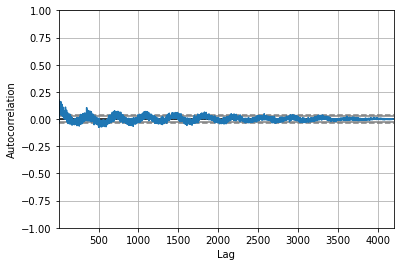

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_diff_1'])
plt.show()

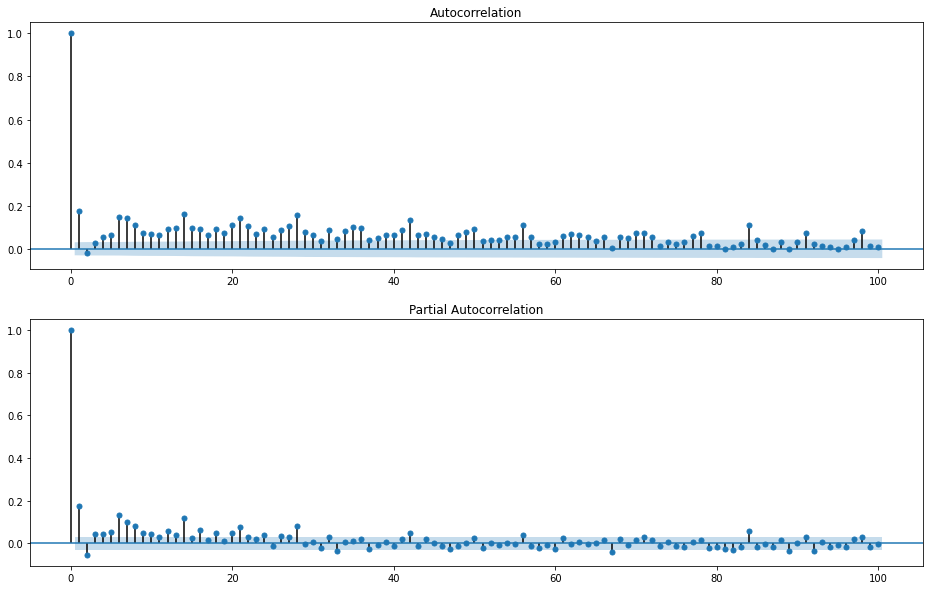

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

plot_acf(df['depth_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_diff_1'], lags=100, ax=ax[1])

plt.show()

Since 0 has the highest correlation for both the Autocorrelation (ACF) Plot and the Partial Autocorrelation (PACF) Plot, we have our terms for our ARIMA model.

- **ACF gives us P**, which is the number of periods to lag for.
- **PACF gives us D**, which is the number of differencing transformations required to make the time series stationary.

From the plots, we get **P=0 and D=0** since we have already made the necessary transformations and cleaning in our previous notebook to make it stationary.

For univariate analysis, we will only have 1 variable. We will **split our time series into training and validation set**.

We will start off by using our **non-stationary depth_p25** target variable. Hence, we will need to add terms to differentiate it.

In [ ]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_p25']].copy()

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(1050)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.1443906841122444


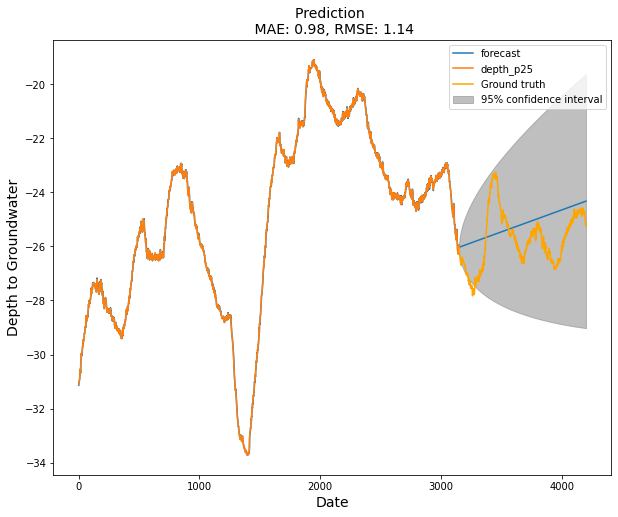

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 8))

model_fit.plot_predict(1, 4199, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['depth_p25'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

As seen from the results, the MAE and RMSE is still very high and the prediction is just a straight line, thus it is not very accurate. Now let us try with the **differentiated depth_diff_1** target variable. Since it is already differentiated, we do not need to add terms.

In [ ]:
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_diff_1']].copy()

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [ ]:
# Fit model
model = ARIMA(y_train, order=(0,0,0))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(1050)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 0.06635018473767014


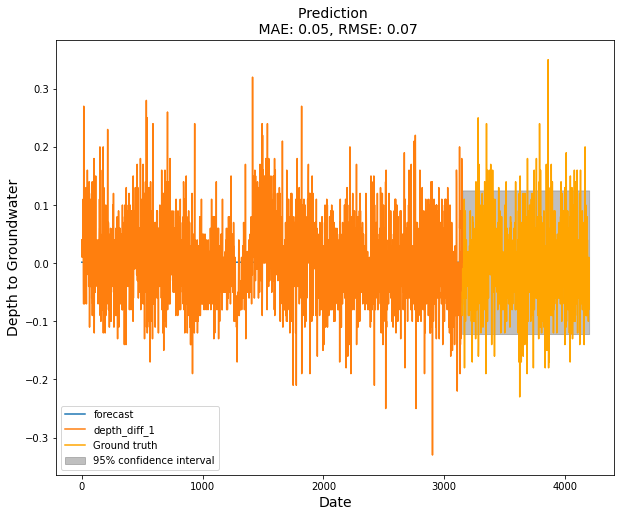

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 8))

model_fit.plot_predict(1, 4199, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['depth_diff_1'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

The model performed **much better with the differenced depth variable**. However, from the plot, we can see that the forecast is very similar to the ground truth, hence the model might have **overfitted** to the training set.

## 2.2) Prophet by Facebook

Because of the difficulty of forecasting time-series data, with many models having many requirements, Prophet was designed as way to **handle data with multiple seasonalities**.

It works as a **sum of 4 terms**: growth g(t), seasonality s(t), holidays h(t) and error e_t.

The **growth function** models the overall trend of the time-series. It can be present at all points or altered at **"changepoints"**, which are points where the data shifts in direction. The power of changepoints over the growth function can also be altered or automatically detected by Prophet.

The **seasonality function** is a Fourier Series as a function of time, and it is the **sum of many successive sines and cosines**. It can be manually input by the user or selected by Prophet automatically.

The **holiday function** allows adjustment of forecasting when there is a major event.

In [ ]:
# since it supports seasonality, we will use the raw depth data (without differencing)

from fbprophet import Prophet

train_size = int(0.75 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_p25']].copy()
univariate_df.columns = ['ds', 'y'] # required by Prophet
univariate_df['ds'] = pd.to_datetime(univariate_df['ds'])

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [ ]:
model = Prophet()
model.fit(train)
y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 1.42620805082148


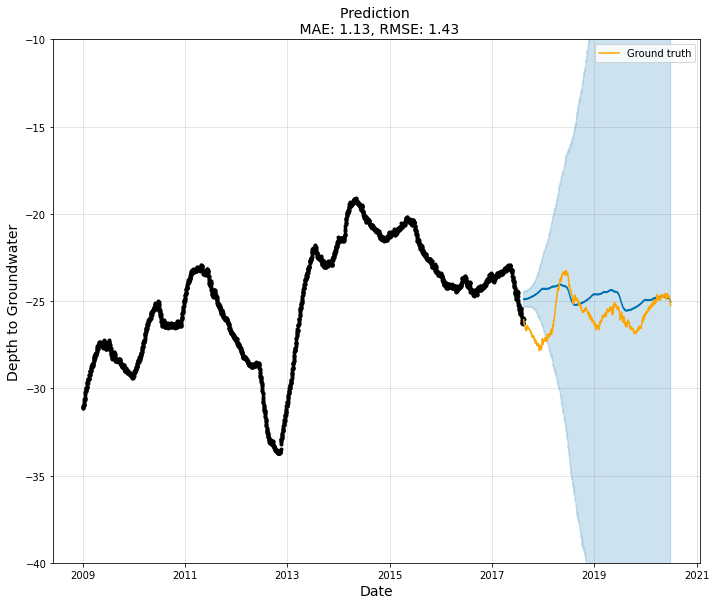

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

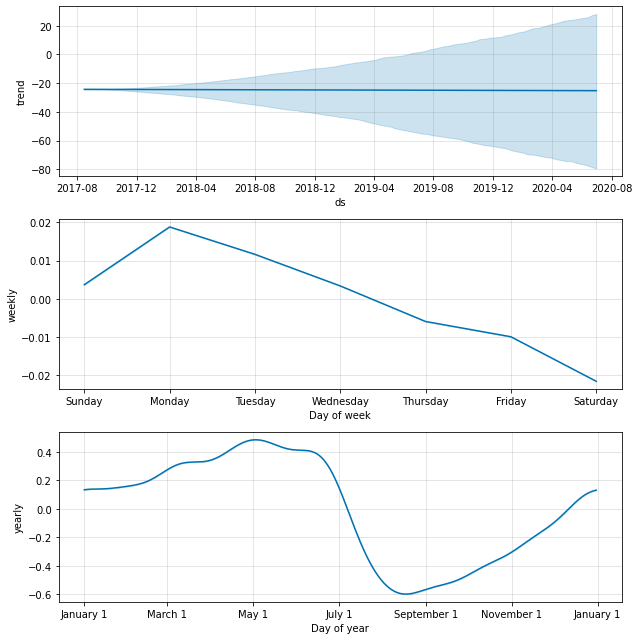

In [ ]:
# show the trends in our data
fig1 = model.plot_components(y_pred)

(-40.0, -15.0)

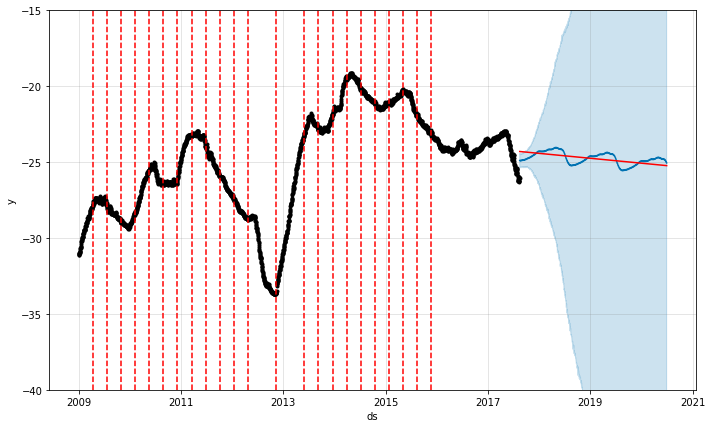

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

# plot the changepoints
fig2 = model.plot(y_pred)
a = add_changepoints_to_plot(fig2.gca(),model,y_pred)
plt.ylim([-40, -15])

From the plot, it can be seen that Prophet does capture the seasonal trends, but it is still not quite accurate. Let us try tuning it further.

The default setting is to use the first 80% of points for changepoint prediction, hence it was not very accurate. We will now tune it to use more points.

**Changepoint prior scale** determines **how much the trend changes at changepoints**, and it should be in the range of [0.001, 0.5], with default of 0.05.

**Changepoint range** determinds the **amount of trend changes that the model will fit to**. [0.8, 0.95] should be a reasonable range, with default of 0.8. The default means that the last 20% of history will not be used to fit the model.

In [ ]:
model = Prophet(changepoint_range=0.9, changepoint_prior_scale=0.005) #prior_scale default of 0.05
model.fit(train)
y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 0.9801574937778347


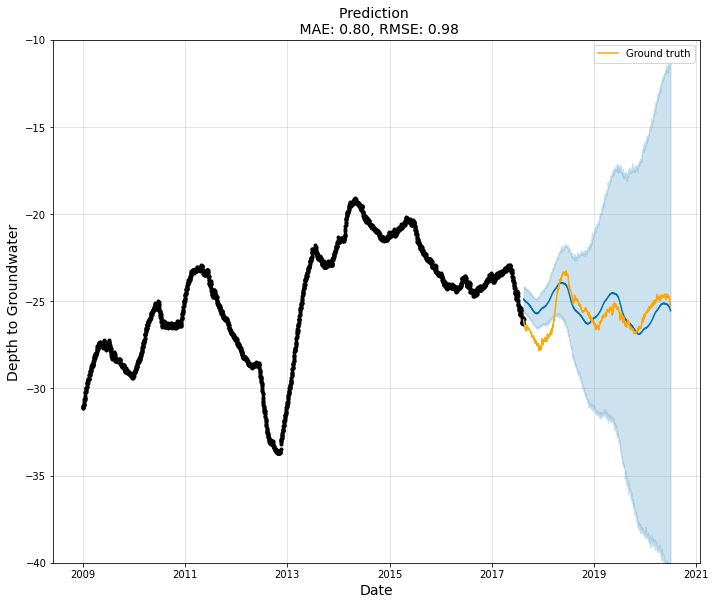

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

After I performed further tuning with changepoint_range and changepoint_prior_scale, I realised the best parameters were 0.9 and 0.005 respectively.

**0.9 of changepoint_range** allowed the use of more points prior to the forecast, where it allowed the model to **capture the downtrend on the year 2017**, allowing it to fit more to the seasonality.

I **reduced the changepoint_prior_scale to 0.005** as the model was putting **too much emphasis on the downtrend in 2017**, causing it to drop very far below. Hence this reduced the impact of this change and allowed the forecast to stay on track.

# 3) Multivariate Time-Series Forecasting

## 3.1) Multivariate FBProphet

We will try to use all of our original features that we have to do a multivariate forecasting of the target feature, which is depth_p25. We do not need the other columns since Prophet accounts for seasonality on its own.

Multivariate forecasting is done by **adding the other features as regressors** to the Prophet model.

In [ ]:
df.head()

,date,rainfall,depth_p25,temp_umbra,volume,hydrometry,depth_diff_1,month,day_of_week,week_of_year,season,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,1,3,1,1,0.5,0.866025,0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,1,4,1,1,0.5,0.866025,-0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,1,5,1,1,0.5,0.866025,-0.974928,-0.222521,0.120208,0.992749,1.0,6.123234e-17
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,1,6,1,1,0.5,0.866025,-0.781831,0.623490,0.120208,0.992749,1.0,6.123234e-17
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,1,0,2,1,0.5,0.866025,0.000000,1.000000,0.238673,0.971100,1.0,6.123234e-17


In [ ]:
from fbprophet import Prophet

train_size = int(0.75 * len(df))
test_size = len(df) - train_size

multivariate_df = df.iloc[:, 0:6]
multivariate_df.rename(columns={'date' : 'ds', 'depth_p25' : 'y'}, inplace=True) # required by Prophet
multivariate_df = multivariate_df[['ds', 'rainfall', 'temp_umbra', 'volume', 'hydrometry', 'y']] #reorder columns
multivariate_df['ds'] = pd.to_datetime(multivariate_df['ds'])
multivariate_df.head()

,ds,rainfall,temp_umbra,volume,hydrometry,y
0,2009-01-01,0.0,5.2,-24530.688,2.4,-31.14
1,2009-01-02,0.0,2.3,-28785.888,2.5,-31.11
2,2009-01-03,0.0,4.4,-25766.208,2.4,-31.07
3,2009-01-04,0.0,0.8,-27919.296,2.4,-31.05
4,2009-01-05,0.0,-1.9,-29854.656,2.3,-31.01


In [ ]:
train = multivariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, 0:5]), pd.DataFrame(multivariate_df.iloc[:train_size, 5])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, 0:5]), pd.DataFrame(multivariate_df.iloc[train_size:, 5])

print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(x_valid)}')

Size of training set: 3149
Size of validation set: 1050


In [ ]:
model = Prophet()
model.add_regressor('rainfall')
model.add_regressor('temp_umbra')
model.add_regressor('volume')
model.add_regressor('hydrometry')
model.fit(train)
y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 1.4200109421616804


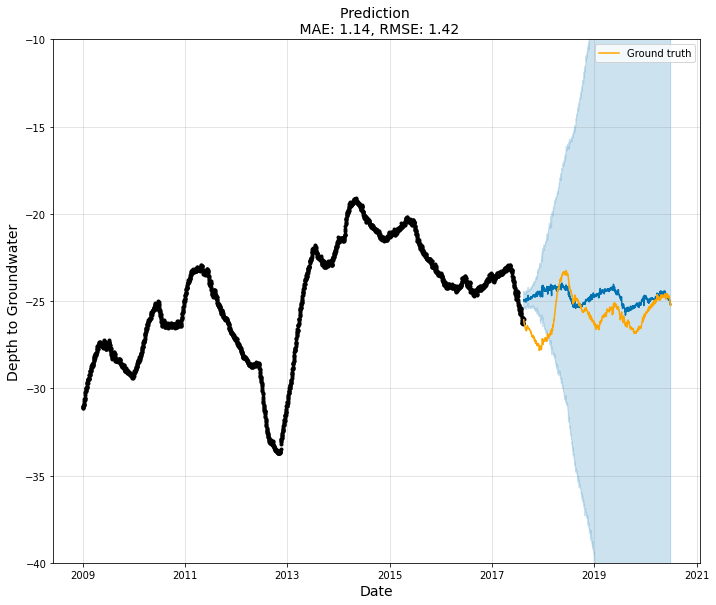

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

Now let's do some tweaking of parameters to improve our model score!

In [ ]:
model = Prophet(changepoint_range=0.9, changepoint_prior_scale=0.005)
model.add_regressor('rainfall')
model.add_regressor('temp_umbra')
model.add_regressor('volume')
model.add_regressor('hydrometry')
model.fit(train)
y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 0.9641155192452531


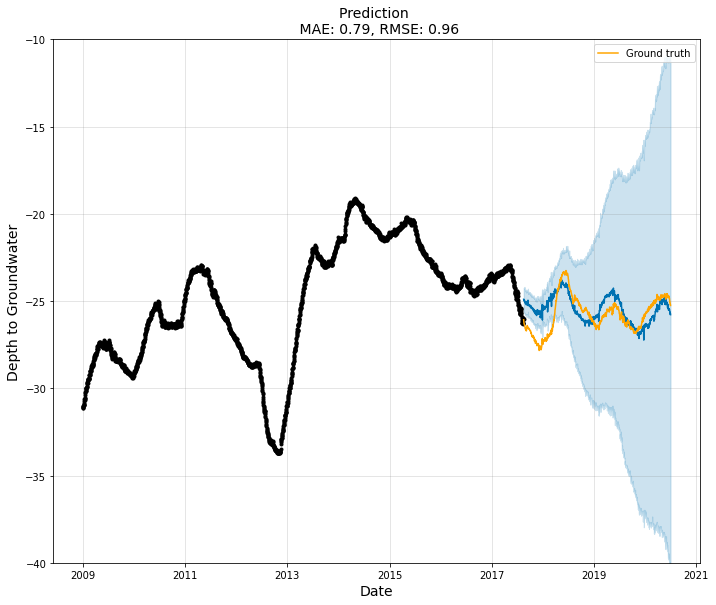

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

The **multivariate model showed slight improvement** from the univariate model, and the plot looks like the model is predicting the changes in trend more accurately.

The **MAE dropped from 0.80 to 0.79**, and the **RMSE dropped from 0.98 to 0.96** when the same parameters were kept, but multivariate features were introduced.

## 3.2) LSTM

Let us try out using neural networks, in particular, a recurrent multi-layered LSTM to do our forecasting with multiple variables.

**Long short-term memory (LSTM)** is a neural network with the RNN architecture that **stores information for a certain period of time**, which is key to understanding time series data, giving rise to its popularity in forecasting use cases.

Before we begin, there are some **data processing steps** we have to go through in order to input our data into our neural network:

- Ensure all data points are float
- Normalize features
- Convert train and test sets into a matrix
- Reshape model input to be (num_samples, num_timesteps, num_features)

In [5]:
df.head()

,date,rainfall,depth_p25,temp_umbra,volume,hydrometry,depth_diff_1,month,day_of_week,week_of_year,season,month_sin,month_cos,day_sin,day_cos,week_sin,week_cos,season_sin,season_cos
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4,0.00,1,3,1,1,0.5,0.866025,0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5,0.03,1,4,1,1,0.5,0.866025,-0.433884,-0.900969,0.120208,0.992749,1.0,6.123234e-17
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4,0.04,1,5,1,1,0.5,0.866025,-0.974928,-0.222521,0.120208,0.992749,1.0,6.123234e-17
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4,0.02,1,6,1,1,0.5,0.866025,-0.781831,0.623490,0.120208,0.992749,1.0,6.123234e-17
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3,0.04,1,0,2,1,0.5,0.866025,0.000000,1.000000,0.238673,0.971100,1.0,6.123234e-17


In [6]:
# get required columns and ensure they are all of float type
lstm_df = df.drop(columns=['depth_diff_1', 'month', 'day_of_week', 'week_of_year', 'season'])
lstm_df.dtypes

date           object
rainfall      float64
depth_p25     float64
temp_umbra    float64
volume        float64
hydrometry    float64
month_sin     float64
month_cos     float64
day_sin       float64
day_cos       float64
week_sin      float64
week_cos      float64
season_sin    float64
season_cos    float64
dtype: object

In [8]:
lstm_df = lstm_df.drop(columns=['date'])
train_size = int(0.75 * len(df))
test_size = len(lstm_df) - train_size
print(lstm_df.shape)
train = lstm_df[:train_size]
test = lstm_df[train_size:]
print(f"Size of training set: {len(train)}")
print(f'Size of validation set: {len(test)}')

(4199, 13)
Size of training set: 3149
Size of validation set: 1050


In [9]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_scaled = x_scaler.fit_transform(train)
print(train_scaled.shape)

train_scaled_y = y_scaler.fit_transform(train[['depth_p25']])
train_scaled_y.shape

(3149, 13)


(3149, 1)

In [10]:
# Reshape model input to be (num_samples, num_timesteps, num_features)
timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, len(train)):
  X_train.append(train_scaled[i-timesteps : i])
  y_train.append(train_scaled_y[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(3119, 30, 13)
(3119,)


In [11]:
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_shape.shape

(3119, 30, 13)

In [12]:
# test if gpu is activated
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

After preparing the data, we will create our LSTM model using Keras. I will try using a **2-layered LSTM model**, with dropouts in between. 

These **dropout layers** help to drop some layer outputs during training, hence changing the configuration of the layer during each epoch. This makes the training process more noisy, forcing more important nodes to take on more responsibility and correct mistakes from prior layers.

We will utilize the **Adam optimizer**, which is a replacement optimization algorithm that combines AdaGrad and RMSProp algorithms, allowing it to handle sparse gradients on noisy problems.

In [ ]:
# create the LSTM model and fit it on the training set
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(30,13)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_shape, y_train, epochs=100, batch_size=32)

Epoch 1/100
98/98 [==============================] - 10s 18ms/step - loss: 0.1256
Epoch 2/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0202
Epoch 3/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0163
Epoch 4/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0140
Epoch 5/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0130
Epoch 6/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0117
Epoch 7/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0106
Epoch 8/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0113
Epoch 9/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0118
Epoch 10/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0100
Epoch 11/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0104
Epoch 12/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0096
Epoch 13/100
98/98 [====

In [14]:
# prepare test data, including the last 30 unused ones from the training set
unused_train = train.iloc[-30:]
test = pd.concat((unused_train, test), axis=0)
test.shape

(1080, 13)

In [15]:
# reshape the test dataset in the same way
test_scaled = x_scaler.transform(test)
X_test_shape = []

for i in range(timesteps, len(test)):
  X_test_shape.append(test_scaled[i-timesteps : i])

X_test_shape = np.array(X_test_shape)
print(X_test_shape.shape)

(1050, 30, 13)


In [ ]:
# now we make predictions with our model on the test set
test_predict = model.predict(X_test_shape)

# invert predictions / remove normalization
predictions = y_scaler.inverse_transform(test_predict)

# find the RMSE and MAE scores
score_rmse = np.sqrt(mean_squared_error(test['depth_p25'][30:], predictions[:,0]))
score_mae = mean_absolute_error(test['depth_p25'][30:], predictions[:,0])
print('RMSE: {}'.format(score_rmse))

RMSE: 0.10303504064932209


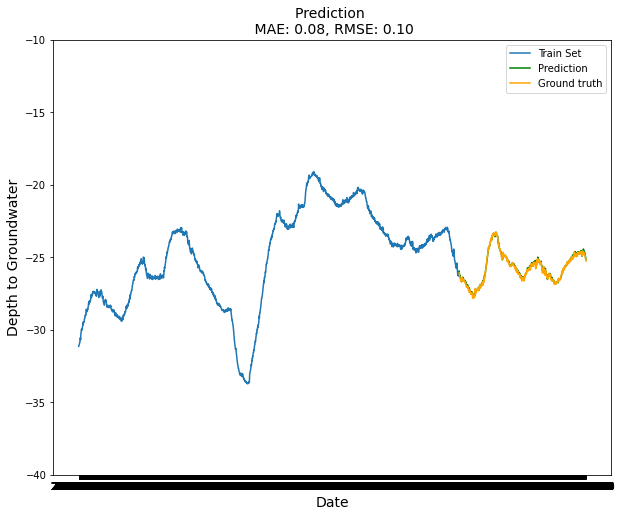

In [ ]:
x_train_ticks = df.head(train_size)['date']
y_train = df.head(train_size)['depth_p25']
x_test_ticks = df.tail(test_size)['date']
y_test = df.tail(test_size)['depth_p25']

# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

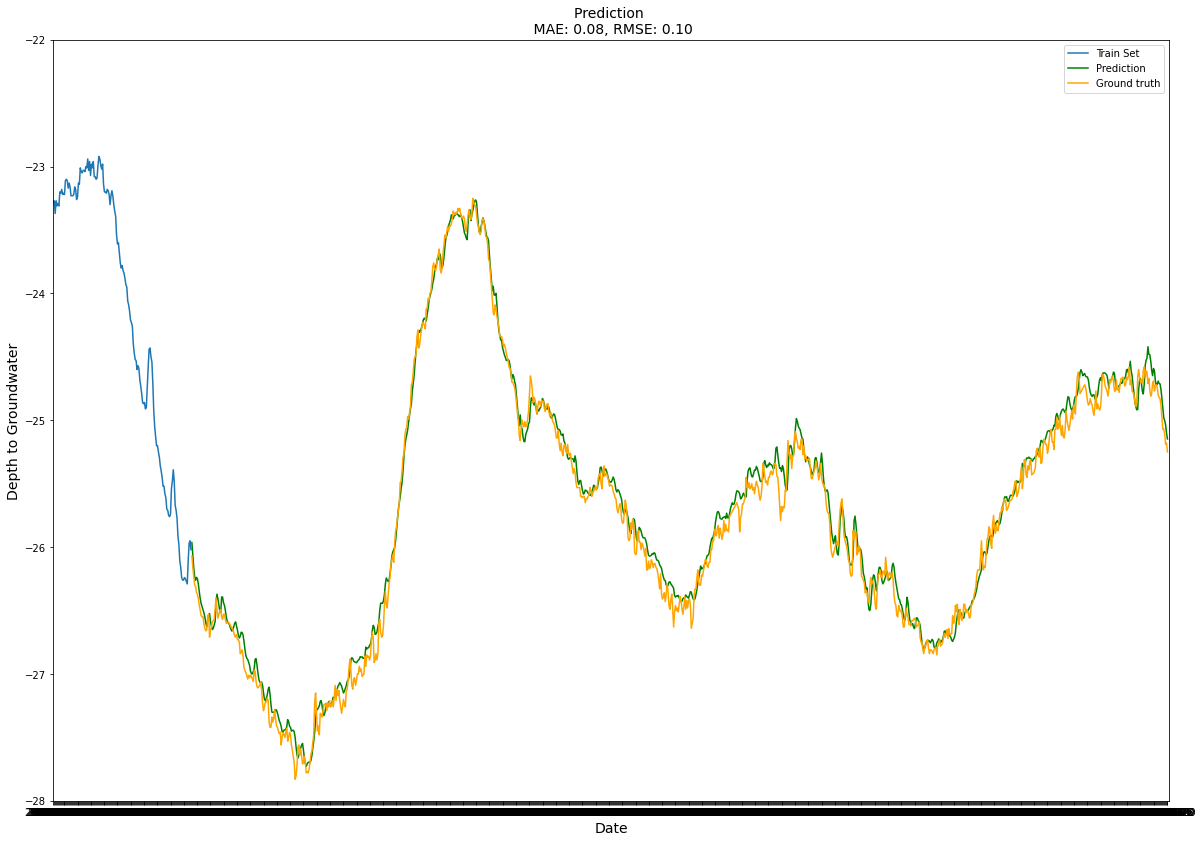

In [ ]:
# Plot the zoomed-in forecast

f, ax = plt.subplots(1, figsize=(20, 14))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-28, -22])
ax.set_xlim([3000, 4200])

plt.show()

From the plots, we can tell that the LSTM model could predict the forecast of the depth of groundwater pretty well. Furthermore, the **MAE and RMSE losses are about 10x smaller** than those of other models, showing the power of neural networks, especially LSTMs, in time-series forecasting.

The LSTM model used earlier was a baseline model used to test the general capability of LSTMs in time-series forecasting. I will now **change the model architecture and tune the hyper-parameters** to try to increase the model performance.

In [30]:
# same preparation steps as before
lstm_df = df.drop(columns=['depth_diff_1', 'month', 'day_of_week', 'week_of_year', 'season'])
lstm_df = lstm_df.drop(columns=['date'])

train_size = int(0.75 * len(df))
test_size = len(lstm_df) - train_size
train = lstm_df[:train_size]
test = lstm_df[train_size:]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_scaled = x_scaler.fit_transform(train)
train_scaled_y = y_scaler.fit_transform(train[['depth_p25']])

timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, len(train)):
  X_train.append(train_scaled[i-timesteps : i])
  y_train.append(train_scaled_y[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

unused_train = train.iloc[-30:]
test = pd.concat((unused_train, test), axis=0)

In [31]:
# try playing around with the parameters to increase model performance

model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(30,13)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_shape, y_train, epochs=300, batch_size=32)

Epoch 1/300
98/98 [==============================] - 12s 30ms/step - loss: 0.0778
Epoch 2/300
98/98 [==============================] - 3s 30ms/step - loss: 0.0195
Epoch 3/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0174
Epoch 4/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0163
Epoch 5/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0150
Epoch 6/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0150
Epoch 7/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0158
Epoch 8/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0132
Epoch 9/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0132
Epoch 10/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0130
Epoch 11/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0132
Epoch 12/300
98/98 [==============================] - 3s 27ms/step - loss: 0.0125
Epoch 13/300
98/98 [====

In [32]:
# now we make predictions with our model on the test set
test_predict = model.predict(X_test_shape)

# invert predictions / remove normalization
predictions = y_scaler.inverse_transform(test_predict)

# find the RMSE and MAE scores
score_rmse = np.sqrt(mean_squared_error(test['depth_p25'][30:], predictions[:,0]))
score_mae = mean_absolute_error(test['depth_p25'][30:], predictions[:,0])
print('RMSE: {}'.format(score_rmse))

RMSE: 0.09615611167961785


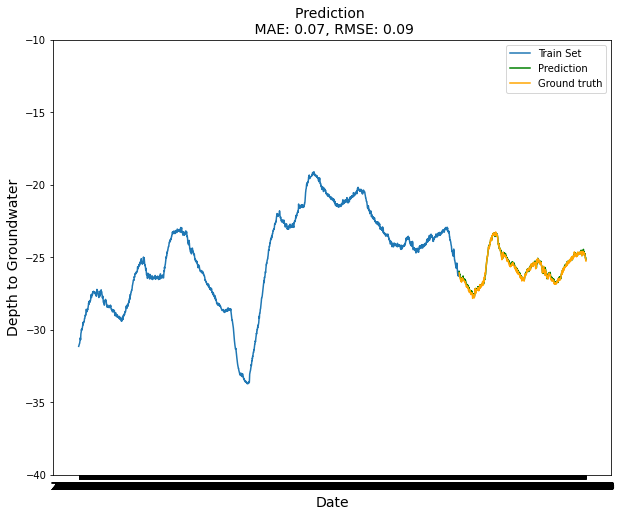

In [22]:
x_train_ticks = df.head(train_size)['date']
y_train = df.head(train_size)['depth_p25']
x_test_ticks = df.tail(test_size)['date']
y_test = df.tail(test_size)['depth_p25']

# Plot the forecast
f, ax = plt.subplots(1, figsize=(10, 8))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-40, -10])

plt.show()

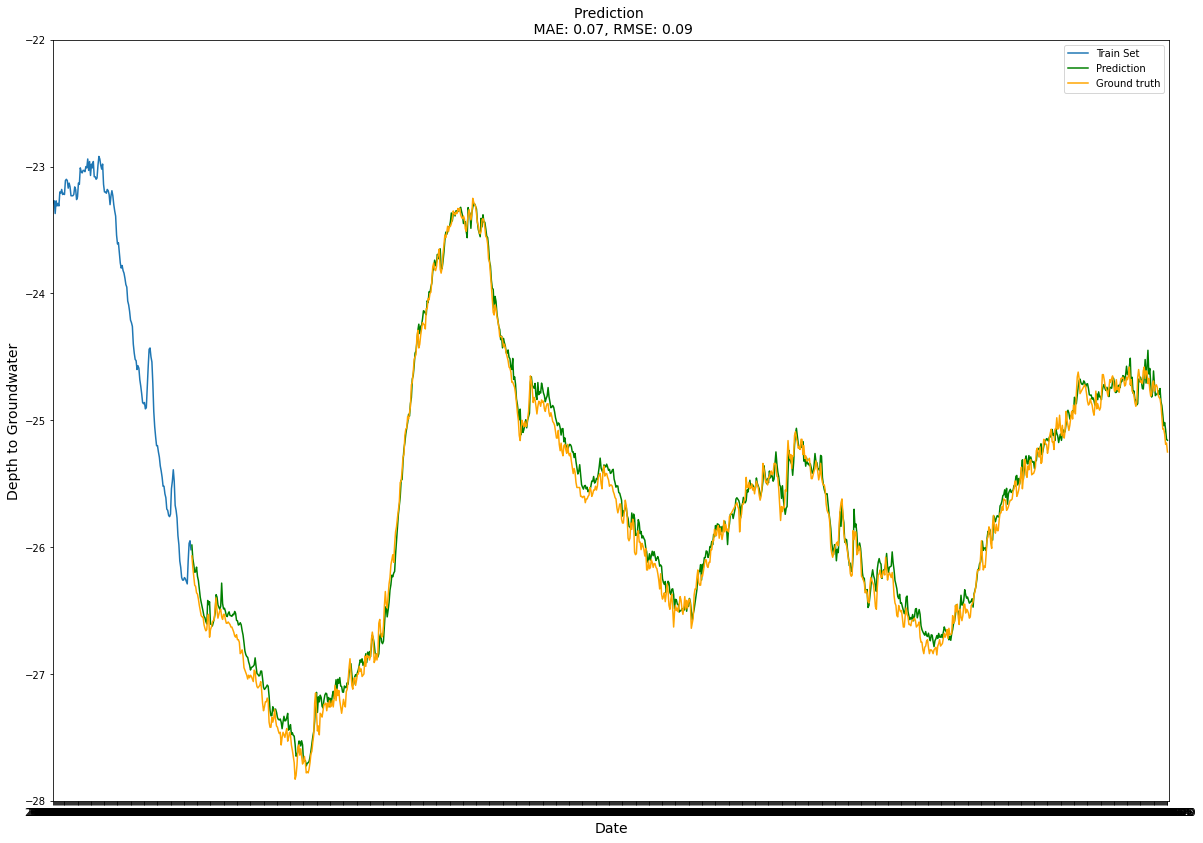

In [23]:
# Plot the zoomed-in forecast

f, ax = plt.subplots(1, figsize=(20, 14))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-28, -22])
ax.set_xlim([3000, 4200])

plt.show()

By increasing the **number of epochs from 100 to 300** and **adding another LSTM layer**, we only get a **slight improvement of 0.01 for both MAE and RMSE**. Hence, let us try other neural networks.

## 3.3) GRU

Another neural network that I am going to try is the **Gated Recurrent Unit (GRU)**. It utilizes the update gate and reset gate to decide what info to pass to the output. These gates help to **keep info from many time steps ahead and to remove irrelevant info**.

A GRU unit is composed of:
- **reset gate**: chooses how much info from previous steps to forget
- **update gate**: chooses how much info to save
- **memory**: brings info along the entire sequence

In [17]:
# same preparation steps as LSTM
gru_df = df.drop(columns=['depth_diff_1', 'month', 'day_of_week', 'week_of_year', 'season'])
gru_df = gru_df.drop(columns=['date'])

train_size = int(0.75 * len(df))
test_size = len(gru_df) - train_size
train = gru_df[:train_size]
test = gru_df[train_size:]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_scaled = x_scaler.fit_transform(train)
train_scaled_y = y_scaler.fit_transform(train[['depth_p25']])

timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, len(train)):
  X_train.append(train_scaled[i-timesteps : i])
  y_train.append(train_scaled_y[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

unused_train = train.iloc[-30:]
test = pd.concat((unused_train, test), axis=0)

# reshape the test dataset in the same way
test_scaled = x_scaler.transform(test)
X_test_shape = []

for i in range(timesteps, len(test)):
  X_test_shape.append(test_scaled[i-timesteps : i])

X_test_shape = np.array(X_test_shape)
print(X_test_shape.shape)

(1050, 30, 13)


In [18]:
# create the GRU model and fit it on the training set
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(30,13)))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_shape, y_train, epochs=100, batch_size=32)

Epoch 1/100
98/98 [==============================] - 6s 16ms/step - loss: 0.1111
Epoch 2/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0255
Epoch 3/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0192
Epoch 4/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0177
Epoch 5/100
98/98 [==============================] - 2s 17ms/step - loss: 0.0154
Epoch 6/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0139
Epoch 7/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0125
Epoch 8/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0118
Epoch 9/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0136
Epoch 10/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0115
Epoch 11/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0132
Epoch 12/100
98/98 [==============================] - 2s 16ms/step - loss: 0.0103
Epoch 13/100
98/98 [=====

In [19]:
# now we make predictions with our model on the test set
test_predict = model.predict(X_test_shape)

# invert predictions / remove normalization
predictions = y_scaler.inverse_transform(test_predict)

# find the RMSE and MAE scores
score_rmse = np.sqrt(mean_squared_error(test['depth_p25'][30:], predictions[:,0]))
score_mae = mean_absolute_error(test['depth_p25'][30:], predictions[:,0])
print('RMSE: {}'.format(score_rmse))

RMSE: 0.19358717036863032


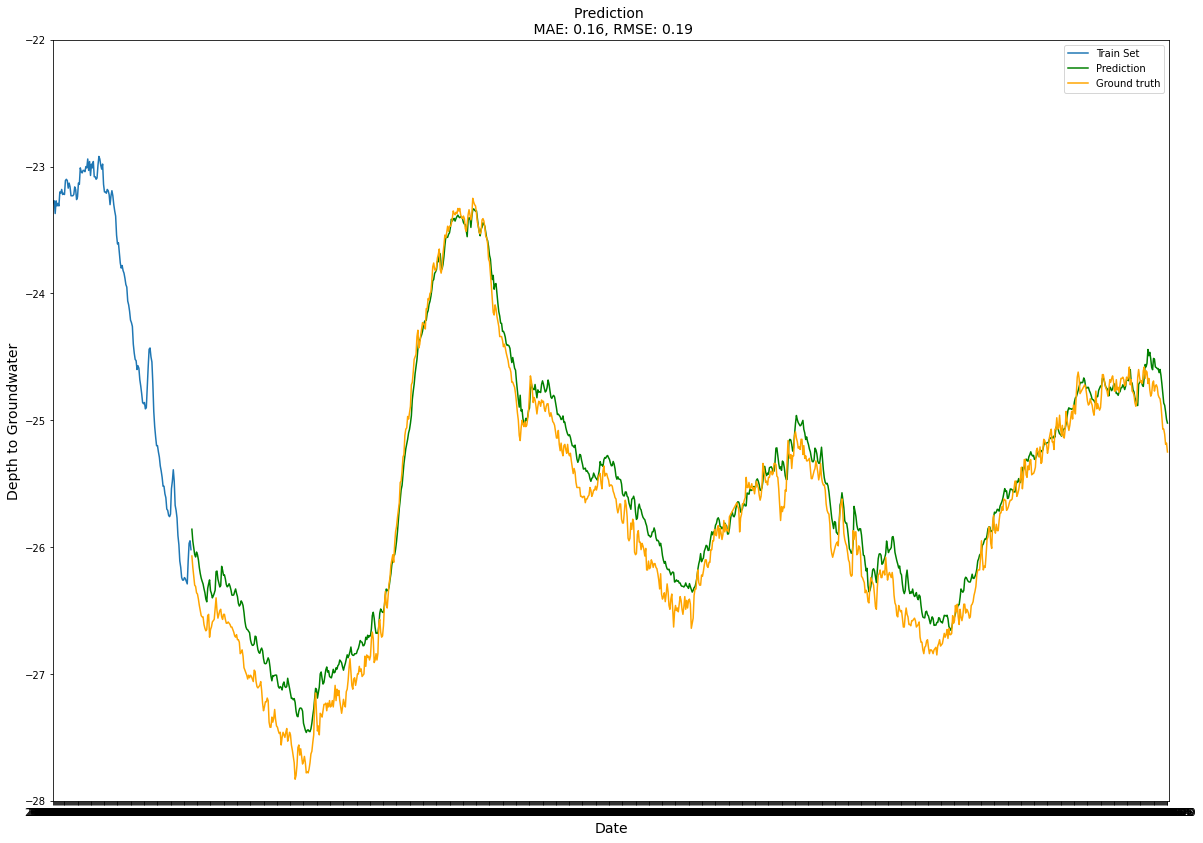

In [21]:
# Plot the zoomed-in forecast
x_train_ticks = df.head(train_size)['date']
y_train = df.head(train_size)['depth_p25']
x_test_ticks = df.tail(test_size)['date']
y_test = df.tail(test_size)['depth_p25']

f, ax = plt.subplots(1, figsize=(20, 14))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-28, -22])
ax.set_xlim([3000, 4200])

plt.show()

From our results, GRU did not perform as well as LSTM! **LSTM performed about 2x better than GRU** in our time-series forecasting problem.

## 3.4) Bi-LSTM

Unlike conventional LSTMs, a **Bidirectional LSTM (Bi-LSTM)** works in a way where you put 2 independent LSTMs together, allowing the network to have both backward and forward information at the same time. Using the two hidden states, we will be able to **preserve information from past and future**. This gives the model a **better understanding of the context**.

In [23]:
# same preparation steps as LSTM
bi_df = df.drop(columns=['depth_diff_1', 'month', 'day_of_week', 'week_of_year', 'season'])
bi_df = bi_df.drop(columns=['date'])

train_size = int(0.75 * len(df))
test_size = len(bi_df) - train_size
train = bi_df[:train_size]
test = bi_df[train_size:]

x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_scaled = x_scaler.fit_transform(train)
train_scaled_y = y_scaler.fit_transform(train[['depth_p25']])

timesteps = 30
X_train = []
y_train = []

for i in range(timesteps, len(train)):
  X_train.append(train_scaled[i-timesteps : i])
  y_train.append(train_scaled_y[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_shape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

unused_train = train.iloc[-30:]
test = pd.concat((unused_train, test), axis=0)

# reshape the test dataset in the same way
test_scaled = x_scaler.transform(test)
X_test_shape = []

for i in range(timesteps, len(test)):
  X_test_shape.append(test_scaled[i-timesteps : i])

X_test_shape = np.array(X_test_shape)
print(X_test_shape.shape)

(1050, 30, 13)


In [24]:
# create the bi-LSTM model and fit it on the training set
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(30,13))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_shape, y_train, epochs=100, batch_size=32)

Epoch 1/100
98/98 [==============================] - 17s 36ms/step - loss: 0.0688
Epoch 2/100
98/98 [==============================] - 3s 35ms/step - loss: 0.0149
Epoch 3/100
98/98 [==============================] - 3s 35ms/step - loss: 0.0116
Epoch 4/100
98/98 [==============================] - 4s 36ms/step - loss: 0.0103
Epoch 5/100
98/98 [==============================] - 3s 35ms/step - loss: 0.0087
Epoch 6/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0084
Epoch 7/100
98/98 [==============================] - 3s 35ms/step - loss: 0.0075
Epoch 8/100
98/98 [==============================] - 4s 36ms/step - loss: 0.0073
Epoch 9/100
98/98 [==============================] - 3s 33ms/step - loss: 0.0070
Epoch 10/100
98/98 [==============================] - 3s 33ms/step - loss: 0.0071
Epoch 11/100
98/98 [==============================] - 3s 33ms/step - loss: 0.0062
Epoch 12/100
98/98 [==============================] - 3s 33ms/step - loss: 0.0078
Epoch 13/100
98/98 [====

In [25]:
# now we make predictions with our model on the test set
test_predict = model.predict(X_test_shape)

# invert predictions / remove normalization
predictions = y_scaler.inverse_transform(test_predict)

# find the RMSE and MAE scores
score_rmse = np.sqrt(mean_squared_error(test['depth_p25'][30:], predictions[:,0]))
score_mae = mean_absolute_error(test['depth_p25'][30:], predictions[:,0])
print('RMSE: {}'.format(score_rmse))

RMSE: 0.2696689445187144


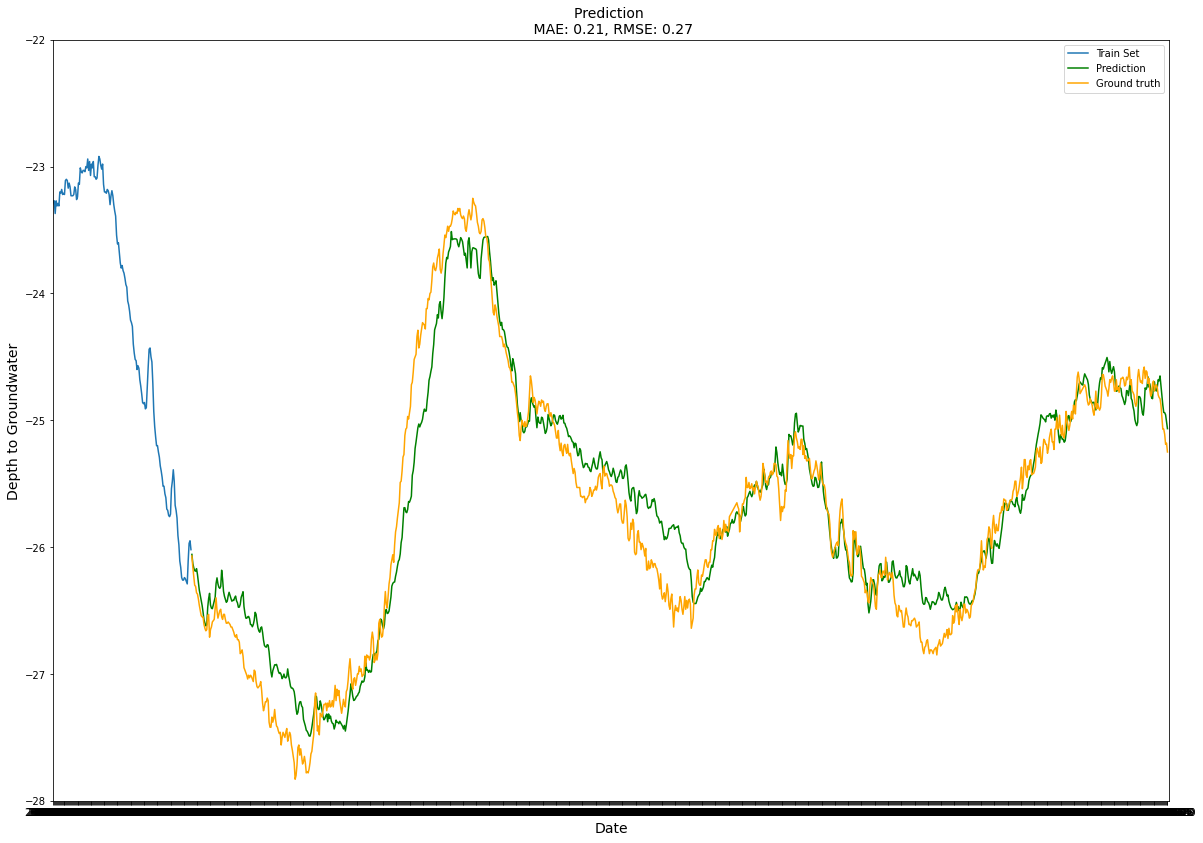

In [26]:
# Plot the zoomed-in forecast
x_train_ticks = df.head(train_size)['date']
y_train = df.head(train_size)['depth_p25']
x_test_ticks = df.tail(test_size)['date']
y_test = df.tail(test_size)['depth_p25']

f, ax = plt.subplots(1, figsize=(20, 14))

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set')
sns.lineplot(x=x_test_ticks, y=predictions[:,0], ax=ax, color='green', label='Prediction')
sns.lineplot(x=x_test_ticks, y=y_test, ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)
ax.set_ylim([-28, -22])
ax.set_xlim([3000, 4200])

plt.show()